# Anonymize data with pandas
[Source](https://dev.to/r0f1/a-simple-way-to-anonymize-data-with-python-and-pandas-79g)

## The Task
The task is to prepare a dataset, such that it can later be used for machine learning purposes (e.g. classification, regression, clustering) without containing any sensitive information. The final dataset should not be too different from the original one and should reflect the initial datasets' distributions.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats

%matplotlib inline

import matplotlib.pyplot as plt
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder

# get rid of warnings
import warnings
warnings.filterwarnings("ignore")

# get more than one output per Jupyter cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# for functions we implement later
from utils import best_fit_distribution
from utils import plot_result

## Data
For our analysis, we will be using the training portion of the Titanic Dataset from Kaggle

In [2]:
df = pd.read_csv("data/titanic_train.csv")

In [3]:
df.shape
df.head()

(891, 12)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Now that we have loaded the data, we are going to strip all the personally identifieable information. The columns `["PassengerId", "Name"]` contain such information. Notice that `["PassengerId", "Name"]` are unique for every row, so if we build a machine learning model, we would drop them anyways later on. Similar arguments can be made about `["Ticket", "Cabin"]`, which are almost unique for every row.

For purposes of this demonstration, we will not deal with missing values. We simply disregard all observations, that contain missing values.

In [4]:
df.drop(columns=["PassengerId", "Name"], inplace=True) # dropped because unique for every row
df.drop(columns=["Ticket", "Cabin"], inplace=True) # dropped because almost unique for every row
df.dropna(inplace=True)

In [5]:
df.shape
df.head()

(712, 8)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Next, to strip even more information, and as a preprocessing step for later, we are going to encode `Sex` and `Embarked` with numeric values. `Sex` will be coded `0,1`, `Embarked` will be coded `0,1,2`. The class `LabelEncoder()` does most of the work for us.

In [6]:
encoders = [(["Sex"], LabelEncoder()), (["Embarked"], LabelEncoder())]
mapper = DataFrameMapper(encoders, df_out=True)
new_cols = mapper.fit_transform(df.copy())
df = pd.concat([df.drop(columns=["Sex", "Embarked"]), new_cols], axis="columns")

C:\Users\anubhav.dhiman\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anubhav.dhiman\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anubhav.dhiman\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anubhav.dhiman\AppData\Local\Continuum\anaconda3

`DataFrameMapper` comes from the `sklearn_pandas` packages and accepts a list of tuples where the first item of the tupels are column names and the second item of the tuples are transformers. For our purposes, we use `LabelEncoder()`, but any other Transformer would be accepted by the interface as well (`MinMaxScaler()`, `StandardScaler()`, `FunctionTransfomer()`). 
In the last line, we join the encoded data with the rest of the data.

In [7]:
df.shape
df.head()

(712, 8)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex,Embarked
0,0,3,22.0,1,0,7.2500,1,2
1,1,1,38.0,1,0,71.2833,0,0
2,1,3,26.0,0,0,7.9250,0,2
3,1,1,35.0,1,0,53.1000,0,2
4,0,3,35.0,0,0,8.0500,1,2


In [8]:
df.nunique()

Survived      2
Pclass        3
Age          88
SibSp         6
Parch         7
Fare        219
Sex           2
Embarked      3
dtype: int64

## Anonymizing by sampling from the same distribution
Above I printed the number of unique values per column. We will go ahead and assume that everything with less than 20 unique values is a nominal or categorical variable, and everything with equal to or more than 20 unique values is a continuous one. Let's put the nominal/categorical variables in one list and the other ones in another list.

In [9]:
categorical = []
continuous = []

for c in list(df):
    col = df[c]
    nunique = col.nunique()
    if nunique < 20:
        categorical.append(c)
    else:
        continuous.append(c)

* For every **categorical** variable, we will determine the frequencies of its unique values, and then create a discrete probability distribution with the same frequencies for each unique value. 
* For every **continuous** variable, we will determine the best continuous distribution from a pre-defined list of distributions. 

Once we have determined all the probability distribution (discrete and continuous), we sample from these distributions to create a new dataset.

## Treatment of nominal/categorical variables

In [10]:
for c in categorical:
        counts = df[c].value_counts()
        np.random.choice(list(counts.index), p=(counts/len(df)).values, size=5)

array([0, 1, 1, 0, 0])

array([1, 3, 3, 1, 3])

array([2, 0, 2, 1, 0])

array([0, 0, 2, 0, 0])

array([1, 0, 1, 1, 1])

array([2, 2, 0, 2, 2])

First, we determine how often a unique value occurs in a variable. This is the empirical probibility function. Then we use this probibility function and pipe it to `np.random.choice()` to create a new random variable that has the same probibility function.

## Treatment of continuous variables
For every continuous variable do:

* Create a histogram using a pre-defined number of bins
* Go though a list of continuous functions, and fit every function to that histogram. This fitting process also yields the parameters for the function.
* The one function that has the smallest error (the smallest residual sum of squares), between itself and the histogram is the one we will use for approximating the continuous variable.

In [11]:
best_distributions = []

In [12]:
for c in continuous:
    data = df[c]
    best_fit_name, best_fit_params = best_fit_distribution(data, 50)
    best_distributions.append((best_fit_name, best_fit_params))

In [13]:
best_distributions

[('fisk', (11.744665309421649, -66.15529969956657, 94.73575225186589)),
 ('halfcauchy', (-5.537941926133496e-09, 17.86796415175786))]

The best distribution for `Age` is `fisk` and the best distribution for `Fare` is `halfcauchy`

C:\Users\anubhav.dhiman\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


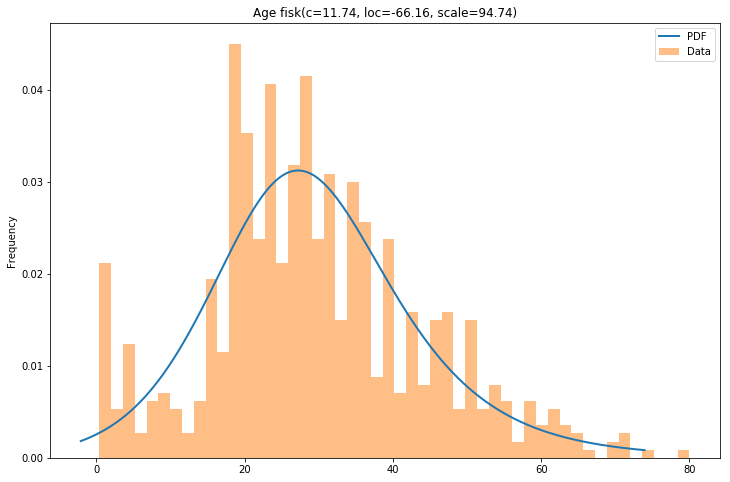

C:\Users\anubhav.dhiman\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


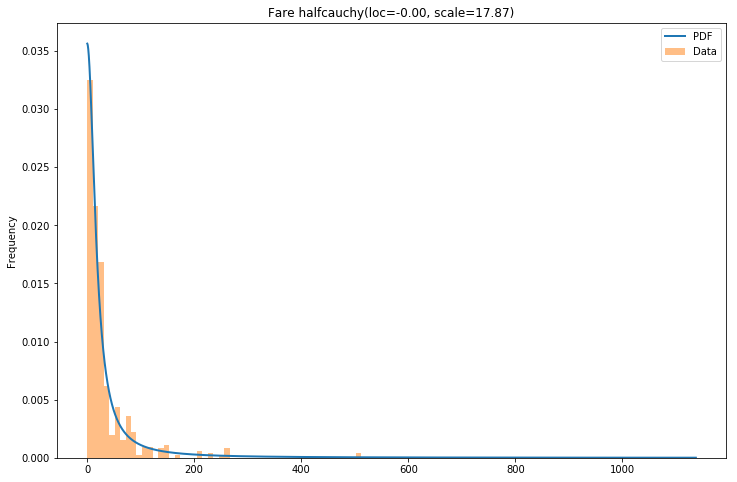

In [14]:
plot_result(df, continuous, best_distributions)

# Putting the codes into one function

In [15]:
def generate_like_df(df, categorical_cols, continuous_cols, best_distributions, n, seed=0):
    np.random.seed(seed)
    d = {}

    for c in categorical_cols:
        counts = df[c].value_counts()
        d[c] = np.random.choice(list(counts.index), p=(counts/len(df)).values, size=n)

    for c, bd in zip(continuous_cols, best_distributions):
        dist = getattr(scipy.stats, bd[0])
        d[c] = dist.rvs(size=n, *bd[1])

    return pd.DataFrame(d, columns=categorical_cols+continuous_cols)

Now we have a function, that we can use to create, say, 100 new observations.

In [16]:
gendf = generate_like_df(df, categorical, continuous, best_distributions, n=100)
gendf.shape
gendf.head()

(100, 8)

,Survived,Pclass,SibSp,Parch,Sex,Embarked,Age,Fare
0,0,1,0,2,1,2,16.846655,11.866699
1,1,3,1,1,0,2,22.967661,6.523808
2,1,1,0,0,1,2,34.873726,2.272420
3,0,2,0,0,0,2,9.149005,2.408852
4,0,3,0,0,0,2,32.161475,6.477172


As a post processing step, one can also round the continuous variables. I chose not to do that. What I did do however, was I deleted all the column names, as this might also leak some infomation about the dataset. I simply replaced them with 0,1,2,... 

In [17]:
gendf.columns = list(range(gendf.shape[1]))
gendf.shape
gendf.head()

(100, 8)

,0,1,2,3,4,5,6,7
0,0,1,0,2,1,2,16.846655,11.866699
1,1,3,1,1,0,2,22.967661,6.523808
2,1,1,0,0,1,2,34.873726,2.272420
3,0,2,0,0,0,2,9.149005,2.408852
4,0,3,0,0,0,2,32.161475,6.477172


Finally, everything is saved to disk.

In [18]:
gendf.to_csv("data/output.csv", index_label="id")

## Final Remarks

One drawback of this approach is that all the interactions between the variables are lost. For example, let's say in the original dataset, women (`Sex=1`) had a higher chance of surviving (`Survived=1`), then man (`Sex=0`). In the generated dataset, this relationship is no longer exsistent. Any other relationship between the variables that might have existed, are lost as well.